## 3D Beamforming Application

this is an app-like jupyter notebook. 


Naming convention of recording file and scanned models:
[Condition]_[distance]_[extranote]

conditions List:
HP1: Jabra ENVOLVE2 75
HP2: Jabra ENVOLVE2 65 Flex
HP3: Jabra ENVOLVE

EP: Earphone, my airpods

GL: VUE Glass

VVS: Volume velocity source

LS: Loudspeaker - Two Units very close to each others - Subwoofer diameter
                                                        10.7cm
                                                      - Twitter dimention: 
                                                      width 2.4cm, heigth 3.4cm

LSTV: Loudspeaker Taped Vent

LSTVBF: Loudspeaker Taped Vend and placed on forward one backward

UC: uncorrelated source

----------------

Distance were measured by a regular ruler, which is a rough number, not necessarily reflect the actural distance

----------------

In [1]:
# this block is for testing, allowd to reload the module soundfieldanalysis
%load_ext autoreload
%aimport SoundFieldAnalysis, acoular, bf3d_prep
%autoreload 1
%aimport

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Modules to reload:
SoundFieldAnalysis acoular bf3d_prep

Modules to skip:



In [2]:
# select the recording file
from bf3d_prep import bf3d_data_prep
import numpy as np

recording_prep = bf3d_data_prep(rootfolder = 'Recordings', filetype = '.mat')

Dropdown(description='Select:', options=('..', 'AP-side-0.6m-12.8kHz-1k6fft.mat', 'bgNoise-HP2-0.70m-2.mat', '…

Button(description='Select', style=ButtonStyle())

Output()

Output()

In [3]:
# select the pcd file
pcd_prep = bf3d_data_prep(rootfolder = 'postPCD', filetype = '.ply')

Dropdown(description='Select:', options=('..', 'AP-align_20231216_122743', 'AP-modify_20231208_161053', 'AP-no…

Button(description='Select', style=ButtonStyle())

Output()

Output()

In [4]:

# import the PCD file and recording data
import open3d as o3d
from data_importer import PointCloudManager, DataExtractor

"""
This block processes point cloud data and extracts audio recording data.

Returns:
- pcd_mic (open3d.geometry.PointCloud): Point cloud data from microphone.
- pcd (open3d.geometry.PointCloud): Point cloud data.
- filtered_pcd (open3d.geometry.PointCloud): Filtered point cloud data.
- recording (numpy.ndarray): Audio recording data.
"""

recording_file = recording_prep.selected_file
pcd_file = pcd_prep.selected_file[:-12]

manager = PointCloudManager()
pcd_mic, pcd, cpcd = manager.load_models(pcd_file)

extractor = DataExtractor(recording_file)
recording = extractor.load_data()

action_log = []

In [5]:
recording_prep.selected_file

# filter out the string within the file name, rule is 
# select the file name between the last \, and the last .mat
# e.g. \path\to\file\file_name.mat -> file_name
recording_name = recording_prep.selected_file.split('\\')[-1].split('.mat')[0]
print(recording_name)

LS-2.83v-0.65m-vent


In [6]:
recording_name = recording_name
print(recording_name)

LS-2.83v-0.65m-vent


In [7]:
# This block will use to reduce the background noise from measured signal

Measured_signal1 = DataExtractor(f'Recordings/JABRA-recordings/GoodSeal-HP1-12.8k-signalChannel.mat')
Measured_signal1 = Measured_signal1.load_data()
Measured_signal2 = DataExtractor(f'Recordings/JABRA-recordings/FrontLose-HP1-12.8k-signalChannel.mat')
Measured_signal2 = Measured_signal2.load_data()
Measured_signal3 = DataExtractor(f'Recordings/JABRA-recordings/BackLose-HP1-12.8k-signalChannel.mat')
Measured_signal3 = Measured_signal3.load_data()
Backgroud_noise = DataExtractor(f'Recordings/JABRA-recordings/BGN-HP1-12.8k.mat')
Backgroud_noise = Backgroud_noise.load_data()

import numpy as np
from scipy.signal import stft, istft

def spectral_subtraction(measured_signal, background_noise, fs=32768):
    """
    Perform generalized spectral subtraction.

    Parameters:
    measured_signal (np.ndarray): The noisy signal, shape (channels, samples).
    background_noise (np.ndarray): The background noise signal, shape (channels, samples).
    fs (int): Sampling rate.

    Returns:
    np.ndarray: The denoised signal, same shape as input signals.
    """
    # Parameters for STFT
    nperseg = 256  # Number of samples per STFT segment
    noverlap = nperseg // 2  # Overlap between segments
    nfft = nperseg  # Number of FFT points

    # Placeholder for the output
    denoised_signal = np.zeros_like(measured_signal)
    signal_spectrum = []
    noise_spectrum = []

    for ch in range(measured_signal.shape[0]):
        # Compute the STFT of both signals
        f, _, Zxx_signal = stft(measured_signal[ch, :], fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        _, _, Zxx_noise = stft(background_noise[ch, :], fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

        # Estimate the magnitude spectrum of noise
        noise_mag = np.abs(Zxx_noise)

        # Perform spectral subtraction
        subtracted_spectrum = np.abs(Zxx_signal) - noise_mag
        subtracted_spectrum[subtracted_spectrum < 0] = 0

        # Reconstruct the signal using the original phase
        denoised_spectrum = subtracted_spectrum * np.exp(1j * np.angle(Zxx_signal))

        # Convert back to time domain
        _, denoised_time_signal = istft(denoised_spectrum, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
        denoised_signal[ch, :len(denoised_time_signal)] = denoised_time_signal
        signal_spectrum.append(np.sum(Zxx_signal, axis=1))
        noise_spectrum.append(np.sum(Zxx_noise, axis=1))
        time_channelnuber = Zxx_signal.shape[1]

    return denoised_signal, signal_spectrum, noise_spectrum, subtracted_spectrum, denoised_spectrum, f, time_channelnuber

# Using the function
denoised_signal, signal_spectrum, noise_spectrum, subtracted_spectrum, denoised_spectrum, frequencys, time_channelnuber = spectral_subtraction(Measured_signal, Backgroud_noise)



KeyboardInterrupt



In [6]:
# this block setup the plotter default aspect ratio and font size

import matplotlib.pyplot as plt
import seaborn as sns

w = 12 / 1.1
h = w * (3 / 10)
ASPECT = (w, h)  # w, h in inches

font_size = 12

# Enable LaTeX rendering + set font size
plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.size": font_size,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.titlesize": font_size,
    }
)

In [7]:
# initialize the Beamformer plotter

from SoundFieldAnalysis import SoundFieldAnalysis
import open3d as o3d

BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=9000)
freq_list = BF_analysis.get_freq_list(freq_range=[3000, 3020], T = 10)

In [9]:
# plot the measured signal and denoised signal and background noise
import matplotlib.pyplot as plt
import numpy as np

sg_spec_db = BF_analysis.dbspl(np.sum(np.array(signal_spectrum), axis=0)/time_channelnuber)
noise_spec_db = BF_analysis.dbspl(np.sum(np.array(noise_spectrum), axis=0)/time_channelnuber)
snr_spec_db = sg_spec_db - noise_spec_db

# plot the measured signal and denoised signal
plt.figure(figsize=ASPECT)
plt.subplot(121)
plt.semilogx(frequencys, sg_spec_db)
plt.semilogx(frequencys, noise_spec_db)
#plt.semilogx(frequencys, BF_analysis.dbspl(np.sum(signal_spectrum-noise_spectrum, axis=1)/subtracted_spectrum.shape[1]))
plt.title('Microphone signal and Background noise')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.legend(['Measured signal - good sealed','Background noise', 'SNR'])
plt.grid()

plt.subplot(122)
plt.semilogx(frequencys, snr_spec_db)
plt.title('SNR')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.grid()
plt.tight_layout()

plt.show()


NameError: name 'signal_spectrum' is not defined

In [ ]:
# plot the measured signal and denoised signal and background noise
import matplotlib.pyplot as plt
import numpy as np

sg_spec_db = BF_analysis.dbspl(np.sum(np.array(signal_spectrum), axis=0)/time_channelnuber)
noise_spec_db = BF_analysis.dbspl(np.sum(np.array(noise_spectrum), axis=0)/time_channelnuber)
snr_spec_db = sg_spec_db - noise_spec_db

# plot the measured signal and denoised signal
plt.figure(figsize=ASPECT)
plt.subplot(121)
plt.semilogx(frequencys, sg_spec_db)
plt.semilogx(frequencys, noise_spec_db)
#plt.semilogx(frequencys, BF_analysis.dbspl(np.sum(signal_spectrum-noise_spectrum, axis=1)/subtracted_spectrum.shape[1]))
plt.title('Microphone signal and Background noise')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.legend(['Measured signal - good sealed','Background noise', 'SNR'])
plt.grid()

plt.subplot(122)
plt.semilogx(frequencys, snr_spec_db)
plt.title('SNR')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB SPL')
plt.grid()
plt.tight_layout()

plt.show()


NameError: name 'signal_spectrum' is not defined

In [6]:
# This block will play the reduced noise signal
import numpy as np
import sounddevice as sd

def play_sound(sound, channel, sample_rate=44100):
    """Play the sound on a specified channel (0 or 1)"""
    if sound.ndim == 1:
        # If the sound is mono, duplicate it for both channels
        sound = np.tile(sound[:, np.newaxis], (1, 2))
    
    # Create a stereo sound array with one channel set to zero
    stereo_sound = np.zeros_like(sound)
    
    if channel == 0:
        # Play on left channel
        stereo_sound[:, 0] = sound[:, 0]
    elif channel == 1:
        # Play on right channel
        stereo_sound[:, 1] = sound[:, 1]
    else:
        raise ValueError("Channel must be 0 or 1")
    
    sd.play(stereo_sound, samplerate=sample_rate)
    sd.wait()


# play the denoised signal
play_sound(denoised_signal[0], channel=0, sample_rate=32768)

NameError: name 'denoised_signal' is not defined

In [8]:

recording_prep.convert_to_h5(recording)


/time_data (EArray(327680, 36)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (455, 36)

In [9]:
# this blcok will save the pcd and pcd_mic to xml file for acoular processing

pcd_prep.save_pcd_to_xml(pcd = cpcd, xml_filename = "pcd_temp_verti.xml", subgrid_name="default")
use_center_pcd = False
use_vertices_pcd = True

In [10]:
# visualize the point cloud and geometry, if the result is not aligned, then use this block for alignment check

# directional wise modification:
# create a coordinate frame by o3d defalut coordinate frame
pcd_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# notation: color for direction x: red, y: green, z: blue, size of the frame: 0.1m for each direction

o3d.visualization.draw_geometries([cpcd, pcd_mic, pcd_frame])

In [10]:
# any modification of alignment to the micpcd should be done here
import copy

mic_translation_matrix = [0,0,0.02]

trranslated_pcd_mic = copy.deepcopy(pcd_mic).translate(mic_translation_matrix)
action_log.append(f"mic_translation_matrix = {mic_translation_matrix}")
print(action_log)
translated_mic = True

# correction note: for lsuc, x0.03
# for signal: x-0.025
# for LS-2.83v: z 0.02

['mic_translation_matrix = [0, 0, 0.02]']


In [13]:
translated_mic = False

In [11]:
if translated_mic:
    pcd_prep.save_pcd_to_xml(pcd = trranslated_pcd_mic, xml_filename = "pcd_mic_temp.xml", subgrid_name="default")
else:
    pcd_prep.save_pcd_to_xml(pcd = pcd_mic, xml_filename = "pcd_mic_temp.xml", subgrid_name="default")

In [12]:
# this block will convet the point cloud data to mesh
# and save the mesh as grid for calculation to xml file

cpcd_mesh, centers_pcd = pcd_prep.mesh_and_center(pcd_mic=pcd_mic, cpcd= cpcd)
pcd_prep.save_pcd_to_xml(pcd = centers_pcd, xml_filename = "pcd_temp_cen.xml", subgrid_name="default")
use_center_pcd = True
use_vertices_pcd = False


In [13]:
r, theta_far, rxyz= pcd_prep.cal_distance_and_angle(cpcd_mesh = cpcd_mesh, 
                                               centers_pcd = centers_pcd, 
                                               pcd_mic = pcd_mic)

In [14]:
# create a grid for bode map plot the plot is to create a grid
# grid as a circle with radius of r = 1.5m, with the center of a specific point position, at xy/yx/xz plane
# the grid is to be used for bode map plot, in total 100 points

def cir_grid(center, normal, radius=1, num_points=100):
    """the function will create a circle grid with radius r, and center at point"""
    """point: center point of the circle"""
    """r: normal vector from the point, on-axis of the circle, theta should be 0 at the normal vector"""
    # Normalize the normal vector
    normal_xy = np.array([normal[0], normal[1], 0])
    normal_xy_norm = np.linalg.norm(normal_xy)
    if normal_xy_norm > 0:
        direction_xy = normal_xy / normal_xy_norm
    else:
        # Default direction if normal is perpendicular to XY plane
        direction_xy = np.array([1, 0, 0])
    
    # Angle between the direction vector and the x-axis
    angle = np.arctan2(direction_xy[1], direction_xy[0])
    
    # Generate circle points
    theta = np.linspace(0, 2*np.pi, num_points)
    x_circle = radius * np.cos(theta)
    y_circle = radius * np.sin(theta)
    
    # Rotate circle points by the angle
    x_rotated = x_circle * np.cos(angle) - y_circle * np.sin(angle)
    y_rotated = x_circle * np.sin(angle) + y_circle * np.cos(angle)
    
    # Translate circle points to the center
    x = center[0] + x_rotated
    y = center[1] + y_rotated
    z = np.full_like(x, center[2])
    
    return x, y, z, theta

# function of this cell is for visualization, you can crop or pick a point, and then choose if to save the cropped point cloud
import pcd_aligner
# modify the model
cpcd_path = f"{manager.directory}/model_2.ply"
mic_path = f"{manager.directory}/model_0.ply"
processor = pcd_aligner.PointCloud_PreProcessor(cpcd_path)
cpcd = processor.pcd_crop(pcd = cpcd, save = False)

picked_points_index = processor.vis.get_picked_points()
centers_pcd.estimate_normals()
normals = np.asarray(centers_pcd.normals)
pick_points_normals = normals[picked_points_index]

# claculate the average normals from the pick_point_normals
average_normals = np.mean(pick_points_normals, axis=0)
average_normals = average_normals/np.linalg.norm(average_normals)

cir_cent_point = np.asarray(cpcd.points[picked_points_index[0]])
# generate the plane vertical to the average normals
# the plane is decided based on first 3 selected points
r_cir = 1 * average_normals

# note: theta from 0 to pi is the back side of the ls, and from pi to 2pi is the front side of the ls
x, y, z, cir_theta = cir_grid(cir_cent_point, average_normals, radius = 1, num_points=100)
pcd_cir_grid = np.array([x, y, z]).T
pcd_cir_grid = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd_cir_grid))


o3d.visualization.draw_geometries([cpcd, pcd_cir_grid])

For point selecting
1) Please pick points using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
For crop the model
Press Y to switch to the ortho view, 
 K to lock the view and pick cropping area 
 C to crop 
 F to free view

 After picking points, press Q to quit, cropped model will be saved in variable "pcd"
[Open3D INFO] Picked point #68616 (-0.046, 0.018, 0.41) to add in queue.
[Open3D INFO] Picked point #38754 (0.0062, 0.0060, 0.4) to add in queue.
[Open3D INFO] Picked point #40626 (0.0050, 0.0050, 0.38) to add in queue.
[Open3D INFO] Picked point #90036 (-0.044, 0.0033, 0.37) to add in queue.
[Open3D INFO] Picked point #121486 (-0.068, 0.0035, 0.37) to add in queue.
[Open3D INFO] Picked point #111081 (-0.098, 0.0037, 0.37) to add in queue.
[Open3D INFO] Picked point #4891 (-0.11, 0.0029, 0.36) to add in queue.
[Open3D INFO] Picked point #10821 (-0.11, 0.0013, 0.34) to add in queue.
[Open3D INFO] Pick

In [26]:
np.linalg.norm(pcd_prep.datas["normals"][1000,:])

0.9999999999999999

In [15]:
theta_far = pcd_prep.datas["theta_far"]
theta_far_deg = np.degrees(theta_far)
theta_far.shape

(160812, 36)

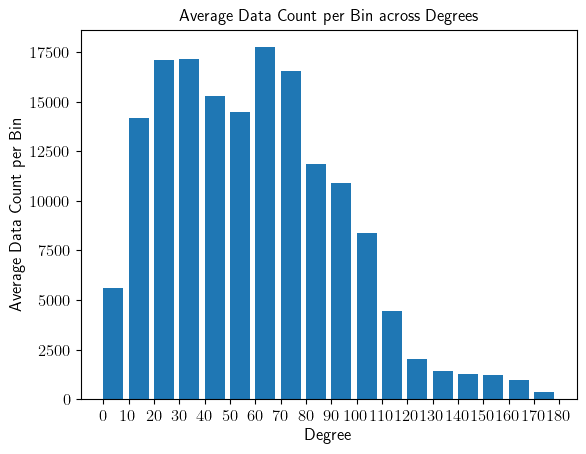

In [16]:
import numpy as np
import matplotlib.pyplot as plt

data = theta_far_deg
degree_bins = np.arange(0, 190, 10) 
degrees = np.linspace(0, 180, num=data.shape[0])

indices = np.digitize(data, degree_bins)

bin_counts = []
std_devs = []

for i in range(1, len(degree_bins)):
    bin_data = data[indices == i]
    bin_count = bin_data.shape[0]

    bin_counts.append(bin_count)
average_counts = [count / 36 for count in bin_counts] 
plt.bar(degree_bins[:-1], average_counts, width=8, align='edge')
plt.xlabel('Degree')
plt.ylabel('Average Data Count per Bin')
plt.title('Average Data Count per Bin across Degrees')
plt.xticks(degree_bins)
plt.show()

In [20]:
# filter the point that with theta less than 30 degree
# get the index of the point that with theta less than 30 degree


# ongoing work

TypeError: select_by_index(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.geometry.PointCloud, indices: List[int], invert: bool = False) -> open3d.cpu.pybind.geometry.PointCloud

Invoked with: PointCloud with 109002 points., (array([     0,      0,      0, ..., 108998, 108998, 108998], dtype=int64), array([ 0,  1,  2, ..., 10, 11, 33], dtype=int64))

In [16]:

display(np.array(centers_pcd.points).shape)

(122968, 3)

In [16]:
# this block setup the acoular beamformer

from os import path

# imports from acoular
import acoular
from acoular import __file__ as bpath, L_p, MicGeom, PowerSpectra,\
RectGrid3D, BeamformerBase, BeamformerCleansc, \
SteeringVector, WNoiseGenerator, PointSource, SourceMixer

# other imports
from numpy import mgrid, arange, array, arccos, pi, cos, sin, sum
import mpl_toolkits.mplot3d
from pylab import figure, show, scatter, subplot, imshow, title, colorbar,\
xlabel, ylabel


micgeofile = 'pcd_mic_temp.xml'
# generate test data, in real life this would come from an array measurement
mg = MicGeom( from_file=micgeofile)

ts = acoular.TimeSamples(name="temp.h5")

ps = acoular.PowerSpectra( time_data=ts, block_size=128, window="Hanning" )

# Create an instance of ImportGrid
grid_importer = acoular.ImportGrid()

# Set the path to your XML file
if use_center_pcd:
    grid_importer.from_file = 'pcd_temp_cen.xml'
elif use_vertices_pcd:
    grid_importer.from_file = 'pcd_temp_verti.xml'

# Call the method to import grid positions
grid_importer.import_gpos()

st = acoular.SteeringVector(mics=mg )
st.grid = grid_importer
st.steer_type = 'true location'



In [19]:
bb = acoular.BeamformerBase(freq_data=ps, steer=st, r_diag=True)
#bc = BeamformerCapon(freq_data=f, steer=st, cached=False)
#be = BeamformerEig(freq_data=f, steer=st, r_diag=True, n=54)
bm = acoular.BeamformerMusic(freq_data=ps, steer=st, n=1)
#bd = acoular.BeamformerDamas(beamformer=bb, n_iter=100)
#bdp = BeamformerDamasPlus(beamformer=bb, n_iter=100)
#bo = BeamformerOrth(freq_data=f, steer=st, r_diag=True, eva_list=list(range(38,54)))
bs = BeamformerCleansc(freq_data=ps, steer=st, r_diag=True)
#bcmf = BeamformerCMF(freq_data=f, steer=st, method='LassoLarsBIC')
#bl = BeamformerClean(beamformer=bb, n_iter=100)
bf = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=4)

In [18]:
print(f"Frequency range: {ps.freq_range} Hz")

Frequency range: [  256. 16384.] Hz


shape of plotc_clamped: (160812,)


c:\Users\lieng\.conda\envs\my_new_env\envs\jpylab-env\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lieng\.conda\envs\my_new_env\envs\jpylab-env\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


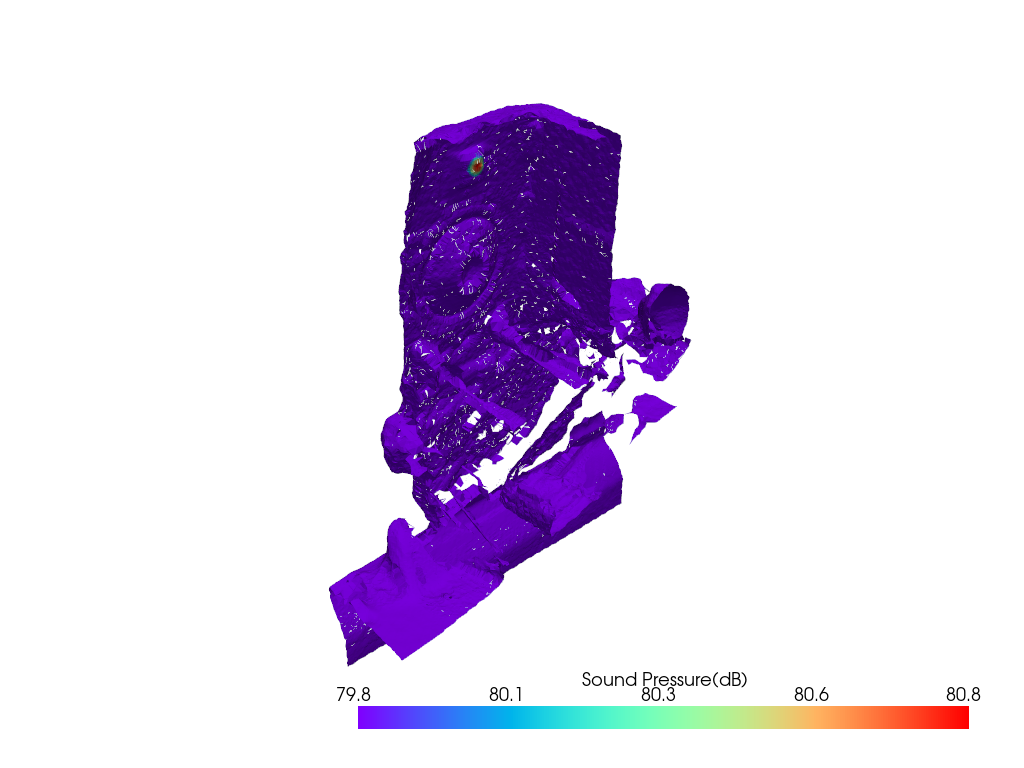

In [22]:
cfreq = 8000 # frequency of interest
pm = bf.synthetic(cfreq,10)
Lm = acoular.L_p(pm)
plotter, p_range = BF_analysis.plot(Lm, dynamic_range=1, 
                                    max_crop=0, 
                                    plot_mesh = True, opacity=True)
# Make sure the rendering is complete
plotter.show()

In [51]:

plotter, cloud = BF_analysis.add_slicer(plotter, mode = bf, p_range = p_range, plane='xz', 
                                           center = [-0.15,0.5],position=0.32, 
                                           size=[0.2, 0.2], plot_mesh=False,
                                           dynamic_range=10, density=100, 
                                           cfreq = 8000, band = 10, opacity="linear")


size of points:  (10000, 3)
[('temp_cache.h5', 21)]
size fo Lm:  (10000,)


In [ ]:
cfreq = 1500 # frequency of interest
import panel as pn

#figure(1,)
#i1 = 1 #no of subplot
for b in (bb, bf):
    #subplot(4,4,i1)
    #i1 += 1
    pm = b.synthetic(cfreq,3)
    Lm = acoular.L_p(pm)
    plotter, p_range = BF_analysis.plot(Lm, dynamic_range=5, max_crop=0, plot_mesh = True, opacity=True)
    # Make sure the rendering is complete
    plotter.show(auto_close=False)
    #file_name = f'Results/3dplot/{b.__class__.__name__}_freq:{cfreq}_{recording_dropdown.value[0:-5]}.html'
    file_name = f'{b.__class__.__name__}_freq_{cfreq}_{recording_prep.selected_file[0:-4]}'
    print(file_name)
    plotter.close()


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21ca1c17580_0&reconnect=auto' style='width…

BeamformerBase_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21ca1c177f0_0&reconnect=auto' style='width…

BeamformerMusic_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21c267a7fd0_0&reconnect=auto' style='width…

BeamformerCleansc_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


Widget(value="<iframe src='http://localhost:56568/index.html?ui=P_0x21ca1bd77f0_0&reconnect=auto' style='width…

BeamformerFunctional_freq_800_LSTVBF-1.6kHz-0.9m-0.07Vrms


In [48]:
freq_list = [2500, 13000] # frequency of interest
import panel as pn

#figure(1,)
#i1 = 1 #no of subplot
for b in (bb, bf):
    for cfreq in freq_list:
        pm = b.synthetic(cfreq,0)
        Lm = acoular.L_p(pm)
        plotter, p_range = BF_analysis.plot(Lm, dynamic_range=30, max_crop=0, plot_mesh = True, opacity=True)
        # Make sure the rendering is complete
        plotter.show(auto_close=False)
        #file_name = f'Results/3dplot/{b.__class__.__name__}_freq:{cfreq}_{recording_dropdown.value[0:-5]}.html'
        file_name = f'{b.__class__.__name__}_freq_{cfreq}_{recording_prep.selected_file[0:-4]}'
        print(file_name)
        plotter.close()


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_21344\3143455354.py:8: Warning: Queried frequency (2500 Hz) not in set of discrete FFT sample frequencies. Using frequency 2560 Hz instead.
  pm = b.synthetic(cfreq,0)
Task exception was never retrieved
future: <Task finished name='Task-6269' coro=<WebSocketWriter.ping() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py:705> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 709, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(

Widget(value="<iframe src='http://localhost:52921/index.html?ui=P_0x1d648db2c20_4&reconnect=auto' style='width…

BeamformerBase_freq_2500_Recordings\JABRA-recordings\GoodSeal-HP1-12.8k-signalChannel


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_21344\3143455354.py:8: Warning: Queried frequency (13000 Hz) not in set of discrete FFT sample frequencies. Using frequency 13056 Hz instead.
  pm = b.synthetic(cfreq,0)


Widget(value="<iframe src='http://localhost:52921/index.html?ui=P_0x1d647335420_4&reconnect=auto' style='width…

BeamformerBase_freq_13000_Recordings\JABRA-recordings\GoodSeal-HP1-12.8k-signalChannel


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_21344\3143455354.py:8: Warning: Queried frequency (2500 Hz) not in set of discrete FFT sample frequencies. Using frequency 2560 Hz instead.
  pm = b.synthetic(cfreq,0)


Widget(value="<iframe src='http://localhost:52921/index.html?ui=P_0x1d648db3190_4&reconnect=auto' style='width…

BeamformerFunctional_freq_2500_Recordings\JABRA-recordings\GoodSeal-HP1-12.8k-signalChannel


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_21344\3143455354.py:8: Warning: Queried frequency (13000 Hz) not in set of discrete FFT sample frequencies. Using frequency 13056 Hz instead.
  pm = b.synthetic(cfreq,0)


Widget(value="<iframe src='http://localhost:52921/index.html?ui=P_0x1d648db36a0_4&reconnect=auto' style='width…

BeamformerFunctional_freq_13000_Recordings\JABRA-recordings\GoodSeal-HP1-12.8k-signalChannel


In [17]:
bf2 = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=2)
bf50 = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=50)
bf500 = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=500)
bf10 = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=10)
bf20 = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=50)
bf200 = acoular.BeamformerFunctional(freq_data=ps, steer=st, r_diag=False, gamma=250)

In [18]:
freq_list = ps.fftfreq()
# interpolate the frequency, only thake 1/3 of the frequency
freq_list= freq_list[1::2][0:-2]


In [19]:

# Initialize a dictionary to hold the lists of pm values for each beamformer
pms_dict = {
    'gamma = 50': [],
}

# List of beamformers and their names for iteration
beamformers = [ (bf50, 'gamma = 50')]




In [70]:

for cfreq in freq_list:
    for b, name in beamformers:
        pm = b.synthetic(cfreq, 0)
        Lm = acoular.L_p(pm)  # Assuming you need to calculate Lm for something else
        pms_dict[name].append(np.sqrt(pm))  # Append pm to the correct list in the dictionary

# step 2: calculate the Tree for find nearest neighbors
cal_points = np.asarray(centers_pcd.points)
tree_info = pcd_prep.build_tree_and_find_neighbors(points = cal_points, k=4)

# step 3: calculate the Gradients with distance.
# Initialize a dictionary to hold the lists of gradient values for each beamformer, the name
# of each beamformer is the same key in the dictionary
gradients_dict = {name: [] for _, name in beamformers}

# Step 2: Efficiently identify edge points

# Step 2: Efficiently identify edge points
_, _, indices_kd_tree = tree_info
cpcd_mesh.compute_triangle_normals()
normals = np.asarray(np.asarray(cpcd_mesh.triangle_normals))

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=200)
dbscan.fit(normals)


DBSCAN(eps=0.05, min_samples=200)

In [71]:

print(f"Number of clusters: {len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)}")


Number of clusters: 9


In [73]:

cluster_labels = dbscan.labels_

edge_points = pcd_prep.identify_edge_points_in_clusters(cal_points,
                                                        tree_info,
                                                         cluster_labels, 
                                                         min_samples=3)



In [74]:
edge_points[edge_points == True].shape

(7718,)

In [41]:
# in this block it will calculate the eigenvalues of simulation data for mutiple configurations

# step 1: load the Beamformer data
freq_list = ps.fftfreq()
# interpolate the frequency, only thake 1/3 of the frequency
freq_list= freq_list[1::3][0:-2]

import panel as pn

# Initialize a dictionary to hold the lists of pm values for each beamformer
pms_dict = {
    'BeamformerDAS': [],
    'BeamformerMusic': [],
    'BeamformerCleanSC': [],
    'BeamformerFunction': []
}

# List of beamformers and their names for iteration
beamformers = [
    (bb, 'BeamformerDAS'),
    (bm, 'BeamformerMusic'),
    (bs, 'BeamformerCleanSC'),
    (bf, 'BeamformerFunction'),
]

for cfreq in freq_list[1:-1]:
    for b, name in beamformers:
        pm = b.synthetic(cfreq, 0)
        Lm = acoular.L_p(pm)  # Assuming you need to calculate Lm for something else
        pms_dict[name].append(np.sqrt(pm))  # Append pm to the correct list in the dictionary


# step 2: calculate the Tree for find nearest neighbors
tree_info = pcd_prep.build_tree_and_find_neighbors(points = np.asarray(centers_pcd.points), k=4)

# step 3: calculate the Gradients with distance.
# Initialize a dictionary to hold the lists of gradient values for each beamformer
gradients_dict = {
    'BeamformerDAS': [],
    'BeamformerMusic': [],
    'BeamformerCleanSC': [],
    'BeamformerFunction': []
}

# Step 2: Efficiently identify edge points
_, _, indices_kd_tree = tree_info
cpcd_mesh.compute_triangle_normals()
normals = np.asarray(np.asarray(cpcd_mesh.triangle_normals))
edge_points, similar_normals_sparse = pcd_prep.calculate_similarity_and_find_edges(normals, indices_kd_tree, threshold=0.95, chunk_size=1000)

shape of plotc_clamped: (160812,)


c:\Users\lieng\.conda\envs\my_new_env\envs\jpylab-env\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\lieng\.conda\envs\my_new_env\envs\jpylab-env\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


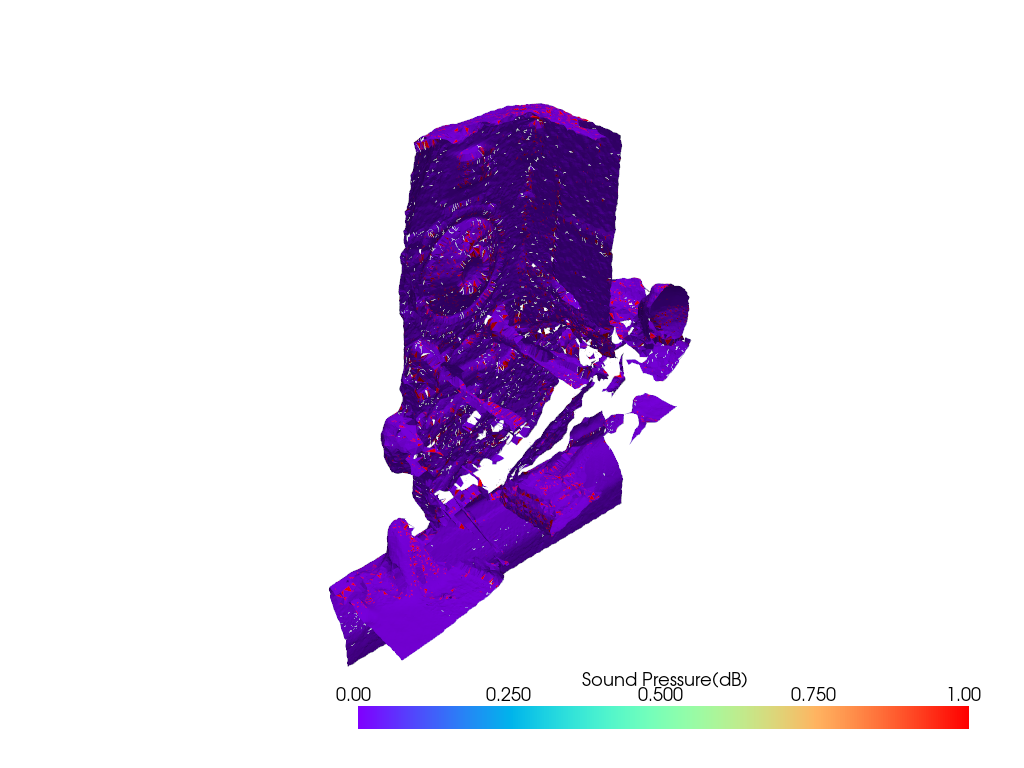

In [75]:
plotter, p_range = BF_analysis.plot(edge_points, dynamic_range=300, max_crop=0, plot_mesh = True, opacity=True)
plotter.show()


In [77]:

# Assuming `centers_pcd` and `neighbors_info` are defined and applicable to all pm calculations
# only cope the name but not the value
gradients_dict = {key: [] for key in pms_dict}

points = np.asarray(centers_pcd.points)
for name, pms_list in pms_dict.items():
    for pm in pms_list:
        gradient = pcd_prep.calculate_gradients(points=points,
                                                values=pm,
                                                tree_info=tree_info)
        adjust_gradients = pcd_prep.adjust_gradients(points,
                                                     edge_points,
                                                     cluster_labels, 
                                                     gradient, 
                                                     min_samples=3)
        gradients_dict[name].append(adjust_gradients)

In [342]:
gradients_dict.keys()

NameError: name 'gradients_dict' is not defined

In [ ]:
from joblib import dump, load

# Assuming `pms_dict`, `gradients_adj_dict`, `freq_list`, and `edge_points` are the variables you want to save
data_to_save = {
    'pms_dict': pms_dict,
    'gradients_dict': gradients_dict,
    'freq_list': freq_list,
    'edge_points': edge_points,
}

# Save to disk
dump(data_to_save, f'CalculateDatas/Gradients/{recording_name}.npz')


['CalculateDatas/Gradients/LSuc-0.8m-60dB-12.8kHzsignal_addup.npz']

In [109]:
from joblib import dump, load

# Load from disk
loaded_data = load(f'CalculateDatas/Gradients/{recording_name}.npz')

# Access your data
pms_dict = loaded_data['pms_dict']
gradients_adj_dict = loaded_data['gradients_adj_dict']
freq_list = loaded_data['freq_list']
edge_points = loaded_data['edge_points']


In [44]:
# read the calculated data from npz file
# Load the data
data = np.load(f'CalculateDatas/Gradients/{recording_name}.npz', 
               allow_pickle=True)
gradients_adj_dict = data['gradients_adj_dict'].item()
pms_dict = data['pms_dict'].item()
freq_list = data['freq_list']
edge_points = data['edge_points']

In [45]:
# list the content of the npz data file

print(f"load data with keys: {data.files}")
print(f"pms_dict names: {pms_dict.keys()}")

load data with keys: ['gradients_adj_dict', 'pms_dict', 'freq_list', 'edge_points']
pms_dict names: dict_keys(['BeamformerDAS', 'BeamformerCapon', 'BeamformerEig', 'BeamformerMusic', 'BeamformerOrth', 'BeamformerFunction'])


In [312]:
# select the data from frequency list, find the cloest freuqnecy from the list and return it's index
freq = 8000

freq_index = np.argmin(np.abs(freq_list - freq))
print(f"selected frequency index: {freq_index}")
G = np.asarray(gradients_adj_dict["gamma = 50"])[freq_index]
N = normals

test_grad = np.sum(G * N, axis=1)
test_grad = np.einsum('ij,ij->i', G, N)
#test_grad = np.asarray(gradients_adj_dict["gamma = 50"])[freq_index] * normals
test_grad = np.multiply(G, N)
# test_grad = np.sum(test_grad, axis=1)
test_grad.shape


selected frequency index: 15


(57628, 3)

In [313]:
plotter, p_range = BF_analysis.plot(BF_analysis.dbspl(test_grad), dynamic_range=100, max_crop=0, plot_mesh = True, opacity=True)
plotter.show()

shape of plotc_clamped: (57628, 3)


Widget(value="<iframe src='http://localhost:55641/index.html?ui=P_0x20c92d71390_81&reconnect=auto' style='widt…

In [ ]:

from bf3d_prep import reverse_sound_field
# step 4: calculate the reverse sound field
rsf = reverse_sound_field(centers_pcd, np.asarray(pcd_mic.points), cpcd, None, freq_list)
rsf.rxyz = rxyz
rsf.normals = normals
re_p_mic_dict = {}
for name in pms_dict.keys():
    re_p_mic = rsf.pressure_at_array_point(r = r, 
                                        theta_far=theta_far, 
                                        f_values = freq_list,
                                        I_list=pms_dict[name], 
                                        grad_p = gradients_adj_dict[name])
    re_p_mic_dict[name] = re_p_mic

In [60]:
np.array(gradients_dict[name][30:]).shape

for name in gradients_dict.keys():
    gradients_adj_dict[name] = gradients_dict[name][30:]


In [ ]:

r_cir, theta_far_cir, rxyz_cir= pcd_prep.cal_distance_and_angle(cpcd_mesh = cpcd_mesh, 
                                               centers_pcd = centers_pcd, 
                                               pcd_mic = pcd_cir_grid)

from bf3d_prep import reverse_sound_field
# step 4: calculate the reverse sound field
rsf = reverse_sound_field(centers_pcd, np.asarray(pcd_mic.points), cpcd, None, freq_list)
rsf.rxyz = rxyz_cir
rsf.normals = normals
re_p_mic_dict = {}
for name in pms_dict.keys():
    re_p_mic = rsf.pressure_at_cir_point(r = r_cir, 
                                        theta_far=theta_far_cir, 
                                        f_values = freq_list, 
                                        I_list=pms_dict[name], 
                                        grad_p = gradients_adj_dict[name])
    re_p_mic_dict[name] = re_p_mic

In [319]:
np.asarray(re_p_mic_dict['gamma = 500']).shape

(30, 36)

In [338]:
cir_bode = np.sum(re_p_mic_dict['gamma = 50'], axis=1)
cir_bode.shape

(30, 100)

In [323]:
import numpy as np

# Assuming your data is stored in 'data.txt'
# The ADAM A5x tested under 2.83v, 1m. The data is from the spinorama data
data_path = "Adam A5x spinorama\SPL Horizontal_onlydata.txt"
import pandas as pd
df = pd.read_csv(data_path, delimiter='\t', on_bad_lines='skip')

# Extract the frequency column (the first column)
frequency = df.iloc[:, 0].str.replace(',', '').astype(float)

# Prepare an empty array to hold the SPL data for each angle
spl_data = []

# Iterate over the SPL columns, which are every other column starting from the second
for i in range(1, len(df.columns), 2):  # Start from 1 and increment by 2 to skip frequency columns
    spl_data.append(df.iloc[:, i].values)

# Convert the list of SPL data into a numpy array
spl_data_np = np.array(spl_data).T  # Transpose to get the shape (Frequency, Angle)

# Verify the shape
print(f"Frequency shape: {frequency.shape}")
print(f"SPL Data shape: {spl_data_np.shape}")



Frequency shape: (193,)
SPL Data shape: (193, 36)


In [96]:
freq_adam_index

171

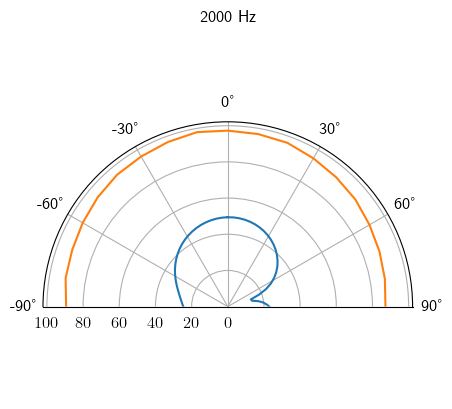

In [341]:
# plot the Polar Plot at specific frequency
import matplotlib.pyplot as plt
import numpy as np

# plot the polar plot
freq = 2000
freq_index = np.argmin(np.abs(freq_list - freq))

freq_adam_index = np.argmin(np.abs(frequency - freq))
# create the theta for the polar plot
# theta is in a squence as "0"		"10°"		"-10°"		"20°"		"-20°"		"30°"		"-30°"		"40°"		"-40°"		"50°"		"-50°"		"60°"		"-60°"		"70°"		"-70°"		"80°"		"-80°"		"90°"		"-90°"		"100°"		"-100°"		"110°"		"-110°"		"120°"		"-120°"		"130°"		"-130°"		"140°"		"-140°"		"150°"		"-150°"		"160°"		"-160°"		"170°"		"-170°"		"180°"	
adam_theta = np.array([0, 10, -10, 20, -20, 30, -30, 40, -40, 50, -50, 60, -60, 70, -70, 80, -80, 90, -90, 100, -100, 110, -110, 120, -120, 130, -130, 140, -140, 150, -150, 160, -160, 170, -170, 180])
# convert the theta to radian
adam_theta = np.radians(adam_theta)

sorted_indices = np.argsort(adam_theta)

# Use these indices to sort both the theta array and the corresponding SPL data
sorted_theta = adam_theta[sorted_indices]
sorted_spl_data = spl_data_np[:, sorted_indices]

db_cir_bode = BF_analysis.dbspl(cir_bode[freq_index, :])
#sorted_spl_data = sorted_spl_data/np.max(sorted_spl_data)*np.max(db_cir_bode)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(cir_theta, db_cir_bode)
ax.plot(sorted_theta, sorted_spl_data[freq_adam_index, :])
#ax.set_rmax(0)
#ax.set_rmin(-30)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
# set the theta range from -90 to 90
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_title(f'{freq} Hz')
plt.show()


In [38]:
freq_list.shape

(30,)

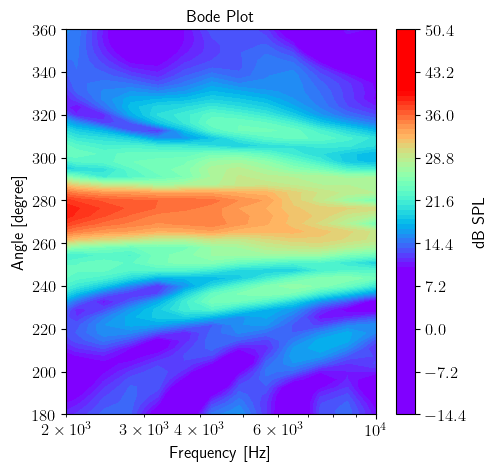

In [157]:
# plot the frequency response of the bode plot, as a heat map, with the angle as x-axis, and frequency as y-axis
import matplotlib.pyplot as plt
import numpy as np

# the cir_bode contain the frequency response regard the angle
# where the first dimension is the frequency, and the second dimension is the angle
# shape of cir_bode is (18, 100)
# the freq_list is the frequency list
# the cir_theta is the angle list

# plot the bode plot
# set the aspect ratio of the plot, as square
x_log = np.logspace(np.log10(freq_list.min()), np.log10(freq_list.max()), len(freq_list))

# Your y-axis and z-axis data preparation remains the same
y = np.degrees(cir_theta)
Z = BF_analysis.dbspl(cir_bode).T  # Assuming this is your dB SPL calculation

fig, ax = plt.subplots(figsize=(5, 5))
# include contour in the map
c = ax.contourf(x_log, y, Z, levels=100, cmap='rainbow')
fig.colorbar(c, ax=ax, label='dB SPL')

ax.set_ylabel('Angle [degree]')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylim(180, 360)
ax.set_xlim(2000, 10000)
c.set_clim(10, 40)
# set a different ticks for y axis instead of using the default ticks
ax.set_xscale('log')  # Apply log scale
ax.set_title('Bode Plot')
plt.show()

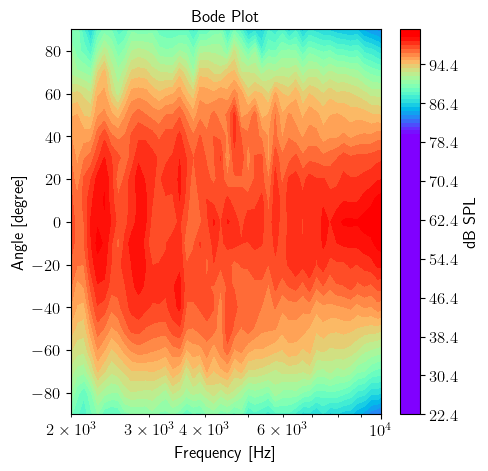

In [139]:

# with the same way, plot the sorted_spl_data
# plot the frequency response of the bode plot, as a heat map, with the angle as x-axis, and frequency as y-axis
x_log = np.logspace(np.log10(frequency.min()), np.log10(frequency.max()), len(frequency))

# Your y-axis and z-axis data preparation remains the same
y = np.degrees(sorted_theta)
Z = (sorted_spl_data).T  # Assuming this is your dB SPL calculation

fig, ax = plt.subplots(figsize=(5, 5))
c = ax.contourf(x_log, y, Z, levels=100, cmap='rainbow')
fig.colorbar(c, ax=ax, label='dB SPL')

ax.set_ylabel('Angle [degree]')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylim(-90, 90)
ax.set_xlim(2000, 10000)
ax.set_xscale('log')  # Apply log scale
# set the color limit
c.set_clim(80, 100)
ax.set_title('Bode Plot')
plt.show()

In [116]:
# print self data's dictionalry;'s elements name and shape one by one
for key in rsf.datas.keys():
    print(key, rsf.datas[key].shape)


grad_p (109002, 3)
r (109002, 36)
theta (109002, 36)
S (109002,)
a (109002, 1)
term (109002, 36)
dgdn (109002, 36)
p (109002, 1)
f ()
G (109002, 36)
dpdn (109002,)


In [87]:
np.asarray(gradients_dict["BeamformerDAS"]).shape

(63, 109002, 3)

In [88]:
normals.shape

(109002, 3)

In [127]:
np.array(ps.csm)[1::2][0:-2].shape

(30, 36, 36)

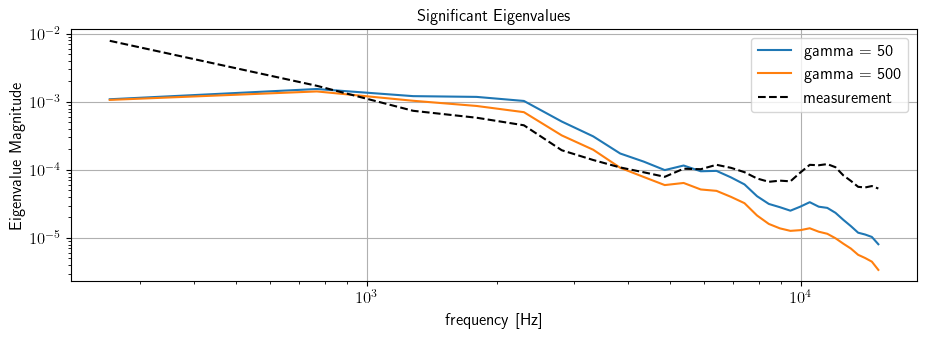

In [131]:


frequencies = freq_list  # Get the list of frequencies
csm = np.array(ps.csm)[1::2][0:-2]  # Calculate and get the Cross Spectral Matrix


plt.figure(figsize=ASPECT)

for name in pms_dict.keys():
    Pf_values = np.abs(re_p_mic_dict[name])
    # calculate the csm of Pf_values
    csm_Pf = np.zeros((len(Pf_values), Pf_values.shape[1], Pf_values.shape[1]))
    for i in range(len(frequencies)):
        csm_Pf[i] = np.outer(Pf_values[i], Pf_values[i].conj())

    error = (csm - csm_Pf)/csm * 100

    eva_csm = np.linalg.eigvals(csm)
    eva_csm_Pf = np.linalg.eigvals(csm_Pf)

    # re-rank the eigenvalues, from large to small
    eva_csm = np.sort(eva_csm, axis=1)
    eva_csm_Pf = np.sort(eva_csm_Pf, axis=1)


    eva_csm_sig = [rsf.get_significant_eva(eva) for eva in eva_csm]
    eva_csm_Pf_sig = [rsf.get_significant_eva(eva) for eva in eva_csm_Pf]

    eva_csm_sum = np.array([np.sum(eva) for eva in eva_csm_sig])
    eva_csm_Pf_sum = np.array([np.sum(eva) for eva in eva_csm_Pf_sig])

    eva_csm_count = np.array([len(eva) for eva in eva_csm_sig])
    eva_csm_Pf_count = np.array([len(eva) for eva in eva_csm_Pf_sig])


    # Plot the significant eigenvalues

    plt.loglog(freq_list, eva_csm_Pf_sum/eva_csm_Pf_count, label = f"{name}")

plt.loglog(freq_list, eva_csm_sum/eva_csm_count, label = f"measurement", linestyle='--', color='black')
plt.title('Significant Eigenvalues')
plt.xlabel('frequency [Hz]')
plt.ylabel('Eigenvalue Magnitude')
# plt.ylim(1e-8, 1e-4)
plt.legend()
plt.grid()


In [1]:
import json

# Specifying the file name
file_name = f'result-{recording_prep.selected_file}.json'

# Writing the dictionary to a file in JSON format
with open(file_name, 'w') as json_file:
    json.dump(re_p_mic_dict, json_file, indent=4)


NameError: name 're_p_mic_dict' is not defined

In [37]:

import panel as pn

#figure(1,)
#i1 = 1 #no of subplot
pms = []
for cfreq in freq_list[1:-1]:
    pm = bs.synthetic(cfreq,0)
    Lm = acoular.L_p(pm)
    pms.append(pm)

[('temp_cache.h5', 4)]


In [38]:
## one very important note: the pm calculated by aculour is the squared sound pressure
## but the Lm is the sound pressure level - when do the L_p is it's calculate based on the squared sound pressure

# so, p = np.sqrt(pm) is the sound pressure
# to extract the actural sound pressure, we take square root of all elements in the list pms
pms = [np.sqrt(pm) for pm in pms]

tree, neighbors_info = pcd_prep.build_tree_and_find_neighbors(points = np.asarray(centers_pcd.points), k=3)

gradients_p = []
for i , pm in enumerate(pms):
    gradient = pcd_prep.calculate_gradients_with_neighbors(points = np.asarray(centers_pcd.points), 
                                                           values=pm, 
                                                           neighbors_info = neighbors_info)

    gradients_p.append(gradient)

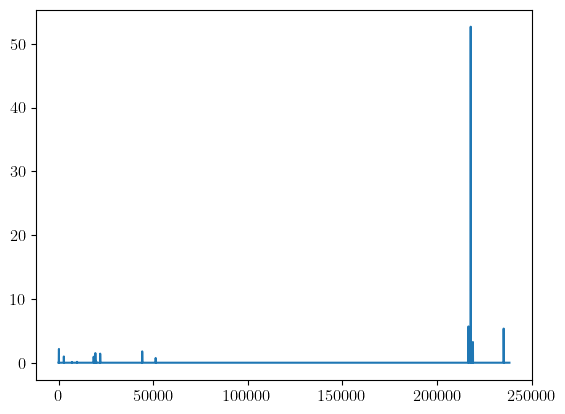

In [39]:
plt.plot(np.abs(gradients_p[0]))

In [40]:
from bf3d_prep import reverse_sound_field

rsf = reverse_sound_field(centers_pcd, np.asarray(pcd_mic.points), cpcd, None, freq_list)

re_p_mic = rsf.pressure_at_array_point(r = r, 
                                       theta_far=theta_far, 
                                       f_values = freq_list[1:-1], 
                                       I_list=pms, 
                                       grad_p = gradients_p)

In [46]:
print(rsf.datas["term"])

[[0.99999805 0.99999762 0.99999645 ... 0.99999545 0.99999347 0.99999053]
 [0.99999797 0.99999674 0.9999948  ... 0.99999414 0.9999911  0.99998774]
 [0.99999151 0.99998784 0.99998386 ... 0.99998354 0.99997813 0.99997383]
 ...
 [0.99972637 0.99970222 0.99968687 ... 0.99968914 0.99967711 0.9996756 ]
 [0.99972187 0.99969195 0.99966872 ... 0.99966715 0.99964535 0.99963576]
 [0.99999257 0.99999354 0.99999443 ... 0.99999379 0.99999496 0.9999949 ]]


In [41]:
Pf_values = (re_p_mic["Pf_values"])
frequencies = ps.fftfreq()[1:-1]  # Get the list of frequencies
csm = np.array(ps.csm)  # Calculate and get the Cross Spectral Matrix

# calculate the csm of Pf_values
csm_Pf = np.zeros((len(Pf_values), Pf_values.shape[1], Pf_values.shape[1]))
for i in range(len(frequencies)):
    csm_Pf[i] = np.outer(Pf_values[i], Pf_values[i].conj())


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_19088\2761167656.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  csm_Pf[i] = np.outer(Pf_values[i], Pf_values[i].conj())


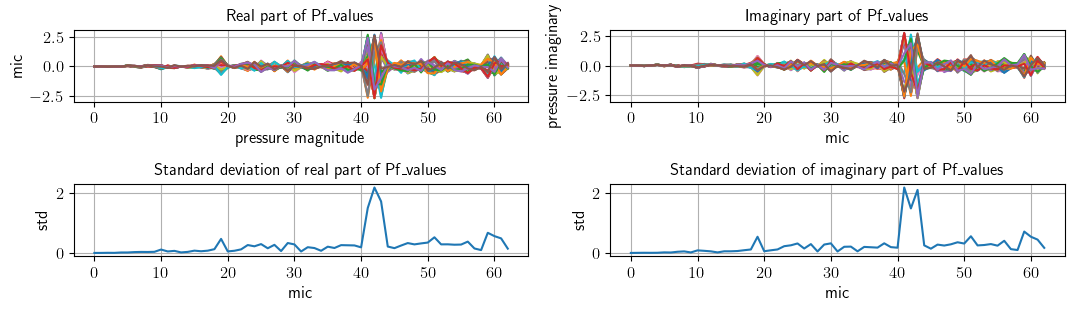

In [42]:
# demonstrate the pf_values, which is the simulated pressure at the microphone

plt.figure(figsize=ASPECT)
plt.subplot(221)
plt.plot(np.real(Pf_values))
plt.title('Real part of Pf_values')
plt.xlabel("pressure magnitude")
plt.ylabel("mic")
plt.grid()
plt.subplot(222)
plt.plot(np.imag(Pf_values))
plt.title('Imaginary part of Pf_values')
plt.ylabel("pressure imaginary")
plt.xlabel("mic")
plt.grid()

# calculate the standard deviation of the Pf_values
plt.subplot(223)
plt.plot(np.std(np.real(Pf_values), axis=1))
plt.title('Standard deviation of real part of Pf_values')
plt.ylabel("std")
plt.xlabel("mic")
plt.grid()

plt.subplot(224)
plt.plot(np.std(np.imag(Pf_values), axis=1))
plt.title('Standard deviation of imaginary part of Pf_values')
plt.ylabel("std")
plt.xlabel("mic")
plt.grid()
plt.tight_layout()
plt.show()


In [43]:
error = (csm[1:-1,:,:] - csm_Pf)/csm[1:-1,:,:] * 100

eva_csm = np.linalg.eigvals(csm[1:-1,:,:])
eva_csm_Pf = np.linalg.eigvals(csm_Pf)


In [44]:
# re-rank the eigenvalues, from large to small
eva_csm = np.sort(eva_csm, axis=1)[:, ::-1]
eva_csm_Pf = np.sort(eva_csm_Pf, axis=1)[:, ::-1]



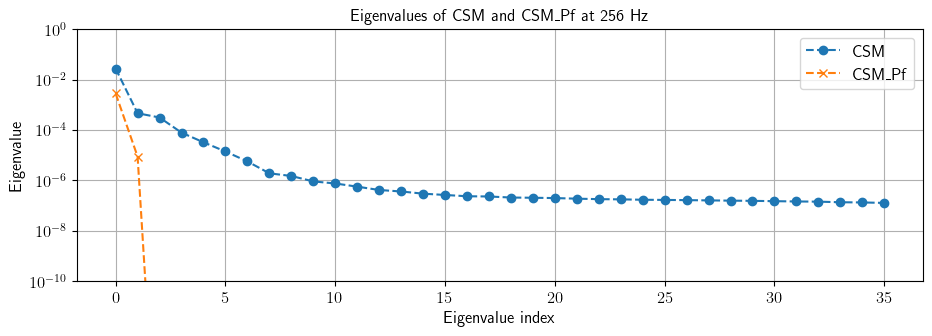

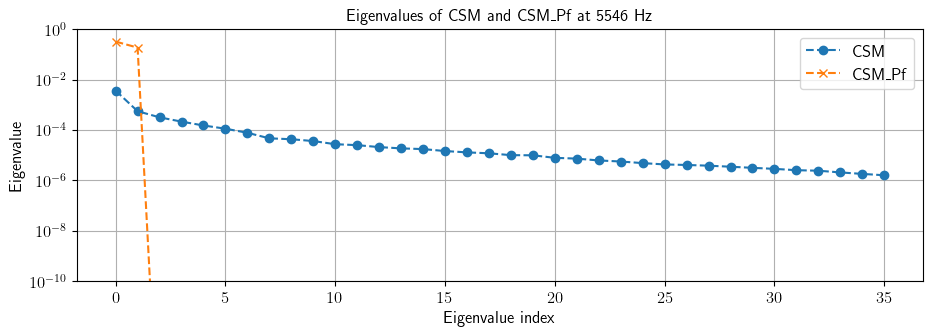

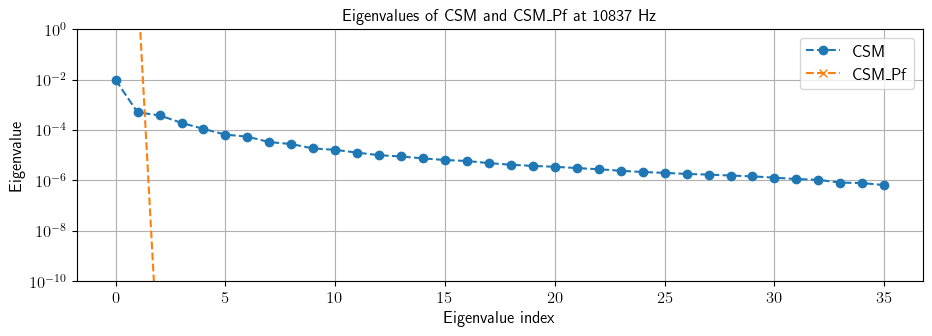

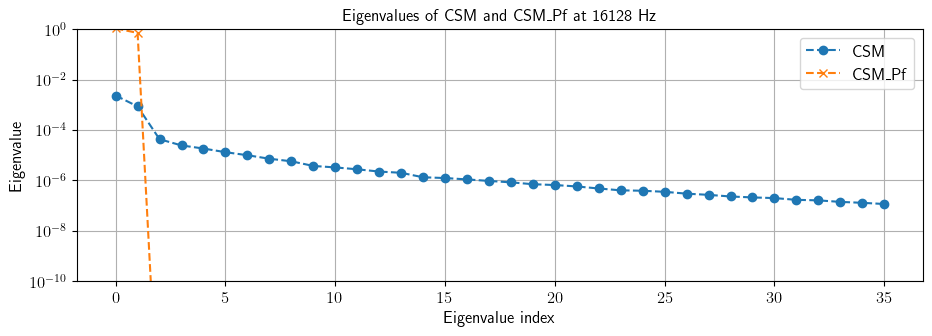

In [45]:
# plt the eigenvalues of the csm and csm_Pf at specific frequency
# find the index of the frequency, if not match, find the closest one
# take 4 frequency points from frequencies, with equal distance
freq = np.linspace(frequencies[0], frequencies[-1], 4, dtype=int)

# generate mutiple subplots with different frequency
for i, freq in enumerate(freq):
    index = np.argmin(np.abs(frequencies - freq))
    plt.figure(figsize=ASPECT)
    plt.subplot()
    plt.semilogy(np.real(eva_csm[index]), linestyle = "--", marker = 'o', label='CSM')
    plt.semilogy(np.real(eva_csm_Pf[index]), linestyle = "--", marker = 'x', label='CSM_Pf')
    plt.title(f'Eigenvalues of CSM and CSM_Pf at {freq} Hz')
    plt.xlabel('Eigenvalue index')
    plt.ylabel('Eigenvalue')
    plt.ylim([1e-10, 1])
    plt.legend()
    plt.grid()
    plt.show()


In [46]:
def get_significant_eva(eva):
    """
    Get the significant eigenvalues of the Cross Spectral Matrix.

    Parameters:
    eva (np.ndarray): Eigenvalues of the Cross Spectral Matrix.

    Returns:
    np.ndarray: Significant eigenvalues.
    """
    # Calculate the mean and standard deviation of the eigenvalues
    mean = np.mean(eva)
    std = np.std(eva)

    # Set a threshold value as a multiple of the standard deviation
    threshold = 2  # Adjust this value as per your requirement

    # Filter out eigenvalues that are significantly larger than the mean
    significant_eva = eva[eva > mean + threshold * std]

    count = len(significant_eva)

    return significant_eva


c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


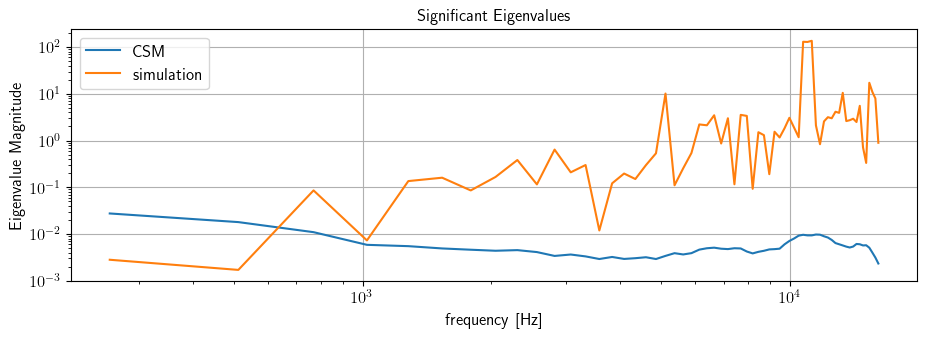

In [51]:
eva_csm_sig = [get_significant_eva(eva) for eva in eva_csm]
eva_csm_Pf_sig = [get_significant_eva(eva) for eva in eva_csm_Pf]

eva_csm_sum = np.array([np.sum(eva) for eva in eva_csm_sig])
eva_csm_Pf_sum = np.array([np.sum(eva) for eva in eva_csm_Pf_sig])

eva_csm_count = np.array([len(eva) for eva in eva_csm_sig])
eva_csm_Pf_count = np.array([len(eva) for eva in eva_csm_Pf_sig])


# Plot the significant eigenvalues
plt.figure(figsize=ASPECT)
plt.loglog(freq_list[1:-1], eva_csm_sum/eva_csm_count)
plt.loglog(freq_list[1:-1], eva_csm_Pf_sum/eva_csm_Pf_count)
plt.title('Significant Eigenvalues')
plt.xlabel('frequency [Hz]')
plt.ylabel('Eigenvalue Magnitude')
plt.legend(['CSM', 'simulation'])
plt.grid()

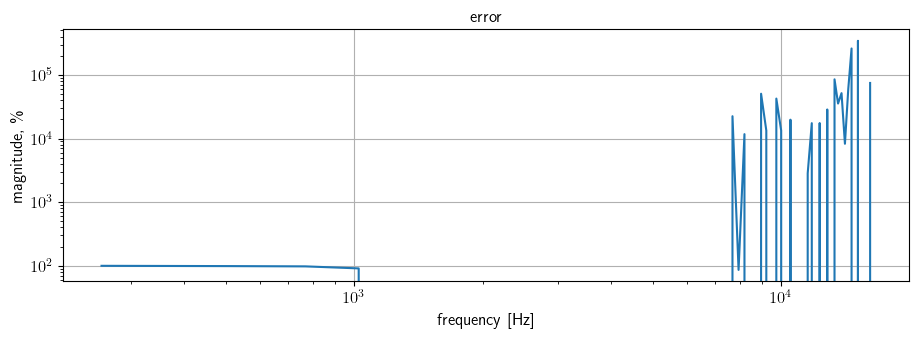

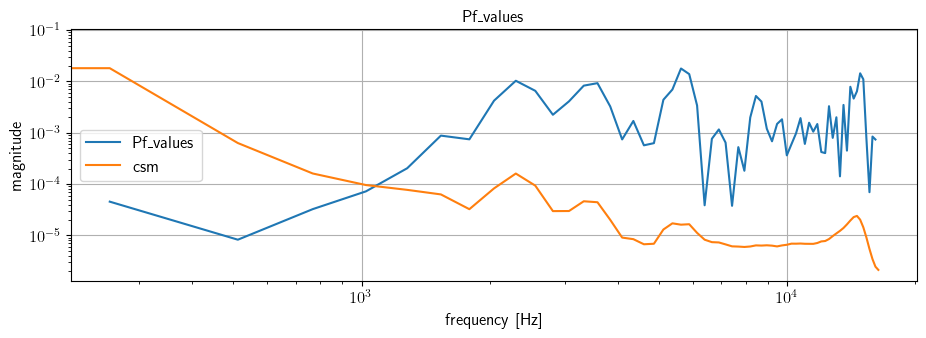

In [26]:
#plot the Pf_values
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=ASPECT)
plt.loglog(freq_list[1:-1], (np.sum((error), axis=(1,2))/(36*36)))
plt.title('error')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude, \%')
plt.grid()
plt.show()

#plot the Pf_values
plt.figure(figsize=ASPECT)
plt.loglog(freq_list[1:-1], (np.sum((csm_Pf), axis=(1,2))))
plt.title('Pf_values')
plt.loglog(freq_list[0:], (np.sum((csm), axis=(1,2))))
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude')
plt.legend(['Pf_values','csm'])
plt.grid()
plt.show()


In [26]:
bb = acoular.BeamformerMusic( freq_data=ps, steer=st)
#bdams = acoular.BeamformerDamas (beamformer = bb, freq_data=ps, steer=st)
#pm = .synthetic( 6000, 3 )
#Lm = acoular.L_p( pm )

pm = bb.synthetic(5000, 3)
Lm = acoular.L_p(pm)


[('temp_cache.h5', 5)]
[('temp_cache.h5', 6)]


In [13]:
bb_Noise = acoular.BeamformerCleansc ( freq_data=ps, steer=st)


#pm = .synthetic( 6000, 3 )
#Lm = acoular.L_p( pm )

pm_noise = bb_Noise.synthetic( 5000, 2 )
Lm = acoular.L_p( pm )

[('temp_cache.h5', 3)]


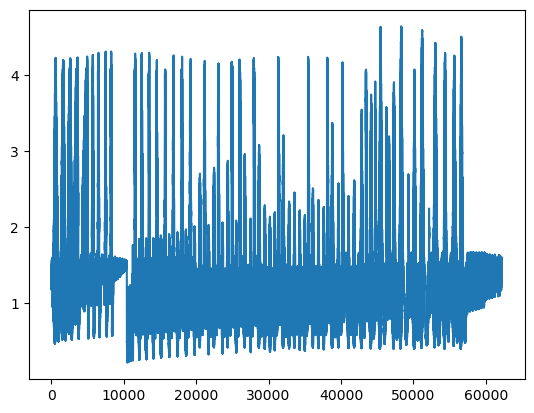

In [27]:
import matplotlib.pyplot as plt

plt.Figure()
plt.plot(Lm)

In [130]:
mesh = rsf.gen_mesh(pcd = cpcd)

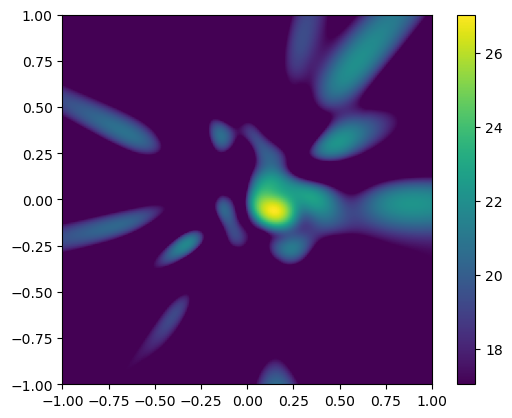

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-10, extent=rg.extend() )
plt.colorbar()

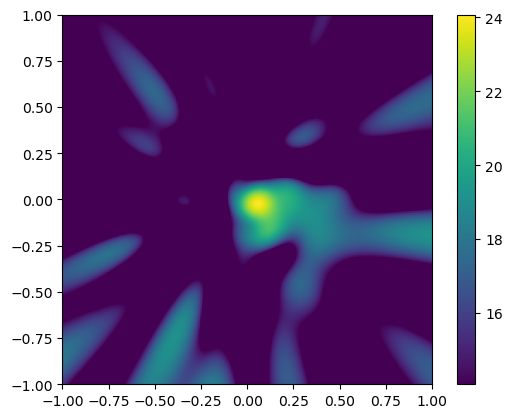

In [ ]:

import matplotlib.pyplot as plt

plt.figure()
plt.imshow( Lm.T, origin="lower", vmin=Lm.max()-10, extent=rg.extend() )
plt.colorbar()

In [ ]:
print( ts.numchannels, ts.numsamples, ts.sample_freq )

36 81920 8192.0


In [ ]:
# this block is for testing, allowd to reload the module soundfieldanalysis
%load_ext autoreload
%aimport SoundFieldAnalysis
%autoreload 1
%aimport

Modules to reload:
SoundFieldAnalysis

Modules to skip:



In [ ]:
# create a button for the calculation

# create a checkbox
checkbox = widgets.Checkbox(
    value=False,
    description='chooese if you want to recalculate the results',
    disabled=False,
    indent=False
)

# display the checkbox
display(checkbox)

# use a function to print the checkbox's value
def on_checkbox_change(change):
    if change['new']:  # while the checkbox is checked
        print("recalculate the results")
    else:
        print("Checkbox is False")

# get the checkbox's current value
checkbox.observe(on_checkbox_change, names='value')

Checkbox(value=False, description='chooese if you want to recalculate the results', indent=False)

recalculate the results


In [ ]:

# select the frequency from the freq_list
mode = 'DAS'

result_muti_DAS = []

result = []
for freq in freq_list:
    cbf_r = []
    cbf_p = []
    # split the pcd_mic and simulation_data into 3 parts
    for i in range(3):
        o3d_pcd_mic = o3d.geometry.PointCloud()
        o3d_pcd_mic.points = o3d.utility.Vector3dVector(pcd_mic.points[i*12:(i+1)*12])
        simulation_data_split = recording[i*12:(i+1)*12,:]

        # initialize the variables
        BF_analysis = SoundFieldAnalysis(o3d_pcd_mic, simulation_data_split, cpcd, freq=freq)
        BF_analysis.calculate_sparse(T = 10)
        BF_analysis.calculate_csm()
        # get the result and add it to the list
        cbf_result, cbf_pressure = BF_analysis.gen_result(mode)
        cbf_r.append(cbf_result)
        cbf_p.append(cbf_pressure)

    print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

    cbf_pressure = (cbf_p[0] * cbf_p[1] * cbf_p[2])**(1/3)
    result_muti_DAS.append(cbf_pressure)

cbf_pressure = np.sum(np.array(result_muti_DAS), axis=0)/4

In [ ]:
from scipy.signal import welch
import pyvista as pv
import cvxpy as cp
import open3d as o3d
import numpy as np

N = np.shape(recording)[1]
fs = N / 10
f, Pxy = welch(recording, fs, noverlap=0, nperseg=1600, return_onesided=True, axis=-1)
Pxy = fs / 1.28 * Pxy

In [ ]:
from SoundFieldAnalysis import SoundFieldAnalysis

freq = 5000
mode = 'DAS'
# initialize the variables
BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=freq)
BF_analysis.calculate_sparse()
BF_analysis.calculate_csm()
# inorder to avoid re-calculation of the same thing
if checkbox.value or 'result' not in globals() or freq != globals()['freq_s'] or mode != globals()['mode_s']:
    cbf_result, cbf_pressure = BF_analysis.gen_result(mode)
    freq_s = freq
    mode_s = mode

print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

the calculated frequency is:  4997.12


c:\ZIM\MasterThesisProject\Stage4\3d_beamforming\SoundFieldAnalysis.py:471: RuntimeWarning: invalid value encountered in log10
  plotc = 20 * np.log10(np.real(result_J / 20e-6))


In [ ]:
from SoundFieldAnalysis import SoundFieldAnalysis

freq = 3000
mode = 'MUSIC1'
# initialize the variables
BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=freq)
BF_analysis.calculate_sparse()
BF_analysis.calculate_csm()
# inorder to avoid re-calculation of the same thing
if checkbox.value or 'result' not in globals() or freq != globals()['freq_s'] or mode != globals()['mode_s']:
    music_result, music_pressure = BF_analysis.gen_result(mode)
    freq_s = freq
    mode_s = mode

print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

the calculated frequency is:  2990.08


In [ ]:
from SoundFieldAnalysis import SoundFieldAnalysis

freq = 300
mode = 'CS'
# initialize the variables
BF_analysis = SoundFieldAnalysis(pcd_mic, recording, cpcd, freq=freq)
BF_analysis.calculate_sparse()
BF_analysis.calculate_csm()
# inorder to avoid re-calculation of the same thing
if checkbox.value or 'result' not in globals() or freq != globals()['freq_s'] or mode != globals()['mode_s']:
    cs_result, _ = BF_analysis.gen_result(mode, 
                                    initial_x = (music_pressure/(music_pressure.max())*(cbf_pressure.max())),
                                    eps = 600e-6, 
                                    max_iters = 10000,
                                    )
    freq_s = freq
    mode_s = mode

print('the calculated frequency is: ', BF_analysis.f[BF_analysis.index])

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 22 01:00:43 PM: Your problem has 53749 variables, 1 constraints, and 0 parameters.
(CVXPY) Jan 22 01:00:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 22 01:00:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 22 01:00:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 22 01:00:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 22 01:00:43 PM: Compiling problem (target solver=SCS).
(C

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [30]:
plotter, p_range = BF_analysis.plot(Lm, dynamic_range=5, max_crop=0,  plot_mesh = True, opacity=True)
# plotter.add_title(f"Beamforming result at {freq} Hz")
plotter.show()

Widget(value="<iframe src='http://localhost:63444/index.html?ui=P_0x18f9be09a50_7&reconnect=auto' style='width…

In [ ]:
import numpy as np
plotter, p_range = BF_analysis.plot(20*np.log10(music_pressure/(music_pressure.max())*(cbf_pressure.max())/20e-6), dynamic_range=2, max_crop=0,  plot_mesh = True, opacity=True)
# plotter.add_title(f"Beamforming result at {freq} Hz")
plotter.show()

c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\pyvista\plotting\mapper.py:637: ComplexWarning: Casting complex values to real discards the imaginary part
  scalars = scalars.astype(float)


Widget(value="<iframe src='http://localhost:49975/index.html?ui=P_0x1e438cb5db0_3&reconnect=auto' style='width…

In [ ]:
# plot the result
plotter, p_range = BF_analysis.plot(cs_result, dynamic_range=10, max_crop=0,  plot_mesh = True, opacity=True)
# plotter.add_title(f"Beamforming result at {freq} Hz")
plotter.show()

Widget(value="<iframe src='http://localhost:54940/index.html?ui=P_0x1d1d3d5f7c0_13&reconnect=auto' style='widt…

In [ ]:

plotter_add_slice, cloud = BF_analysis.add_slicer(plotter, mode, p_range = p_range, plane='xz', 
                                           center = [0.05,0.2],position=0.2, 
                                           size=[1, 1], plot_mesh=False,
                                           dynamic_range=50, density=200)


In [ ]:
import pyvista as pv
plotter_plane = pv.Plotter()
plotter_plane.add_mesh(cloud, cmap='rainbow', scalars='Sound Pressure(dB)',show_scalar_bar = True, point_size = 6)
plotter_plane.show()

Widget(value="<iframe src='http://localhost:57773/index.html?ui=P_0x184d10b67d0_26&reconnect=auto' style='widt…

Exception raised
ConnectionResetError('Cannot write to closing transport')
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 340, in onMessage
    await self.sendWrappedMessage(
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\Ap

 JS Error => Malformed message:  {"wslink": "1.0", "id": "publish:trame.vtk.delta:0", "result": {"parent": "0x0", "id": 27, "type": "vtkWin32OpenGLRenderWindow", "properties": {"numberOfLayers": 2}, "dependencies": [{"parent": "000001855339b9f0", "id": "00000184d7e1cde0", "type": "vtkOpenGLRenderer", "properties": {"background": [1.0, 1.0, 1.0], "background2": [0.2, 0.2, 0.2], "viewport": [0.0, 0.0, 1.0, 1.0], "twoSidedLighting": 1, "lightFollowCamera": 1, "layer": 0, "preserveColorBuffer": 0, "preserveDepthBuffer": 0, "nearClippingPlaneTolerance": 0.001, "clippingRangeExpansion": 0.5, "useShadows": 0, "useDepthPeeling": 0, "occlusionRatio": 0.0, "maximumNumberOfPeels": 4, "interactive": 1}, "dependencies": [{"parent": "00000184d7e1cde0", "id": "00000185951be980", "type": "vtkOpenGLCamera", "properties": {"focalPoint": [0.05000000000000002, 0.2, 0.19999999999999998], "position": [1.6273502691896262, 1.7773502691896261, 1.7773502691896261], "viewUp": [0.0, 0.0, 1.0], "clippingRange": [1

In [ ]:

plotter_add_slice, cloud = BF_analysis.add_slicer(plotter, mode, p_range = None, plane='yz', 
                                           center = [0,0.2],position=0.2, 
                                           size=[1, 1], plot_mesh=False,
                                           dynamic_range=80, density=500)

Task exception was never retrieved
future: <Task finished name='Task-1086' coro=<WslinkHandler.sendWrappedMessage() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py:423> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\wslink\protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, com

In [ ]:

plotter_plane = pv.Plotter()
plotter_plane.add_mesh(cloud, cmap='rainbow', scalars='Sound Pressure(dB)',show_scalar_bar = True, point_size = 6)
plotter_plane.show()

Task exception was never retrieved
future: <Task finished name='Task-1103' coro=<WebSocketWriter.ping() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py:705> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 709, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 696, in _write
    raise ConnectionResetError("Cannot write to closing transport

Widget(value="<iframe src='http://localhost:65350/index.html?ui=P_0x20d9c048220_42&reconnect=auto' style='widt…

In [128]:
# function of this cell is for visualization, you can crop or pick a point, and then choose if to save the cropped point cloud
import pcd_aligner
# modify the model
cpcd_path = f"{manager.directory}/model_2.ply"
mic_path = f"{manager.directory}/model_0.ply"
processor = pcd_aligner.PointCloud_PreProcessor(cpcd_path)
cpcd = processor.pcd_crop(pcd = cpcd, save = False)

For point selecting
1) Please pick points using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
For crop the model
Press Y to switch to the ortho view, 
 K to lock the view and pick cropping area 
 C to crop 
 F to free view

 After picking points, press Q to quit, cropped model will be saved in variable "pcd"
[Open3D INFO] Picked point #36963 (0.12, 0.061, 0.41) to add in queue.


In [ ]:
# this block calculate the frequency response of the picked point

import numpy as np

freq_list = BF_analysis.calculate_sparse(freq_range=[10, 8000])

points_np = np.asarray(cpcd.points)
picked_points_index = processor.vis.get_picked_points()
picked_points = points_np[picked_points_index]
single_point_pcd = o3d.geometry.PointCloud()

# store the picked points in a point cloud
single_point_pcd.points = o3d.utility.Vector3dVector(picked_points)

result_muti_MUSIC = []
result_muti_DAS = []

result = []
for freq in freq_list:
    # set the current frequency
    BF_analysis.freq = freq
    mode = 'MUSIC1'
    # initialize the variables
    BF_analysis.mic_pcd = pcd_mic
    BF_analysis.sound_field = recording
    BF_analysis.pcd = single_point_pcd
    BF_analysis.points = np.array(single_point_pcd.points)

    BF_analysis.calculate_csm()
    result, _ = BF_analysis.gen_result(mode)
    result_muti_MUSIC.append(result)

result = []
for freq in freq_list:
    # set the current frequency
    BF_analysis.freq = freq
    mode = 'DAS-Non-splice'

    BF_analysis.calculate_csm()
    result,_ = BF_analysis.gen_result(mode)
    result_muti_DAS.append(result)


IndexError: index 12 is out of bounds for axis 0 with size 12

In [79]:
# this block setup the plotter default aspect ratio and font size

import matplotlib.pyplot as plt
import seaborn as sns

w = 12 / 1.1
h = w * (3 / 10)
ASPECT = (w, h)  # w, h in inches

font_size = 12

# Enable LaTeX rendering + set font size
plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.size": font_size,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.titlesize": font_size,
    }
)

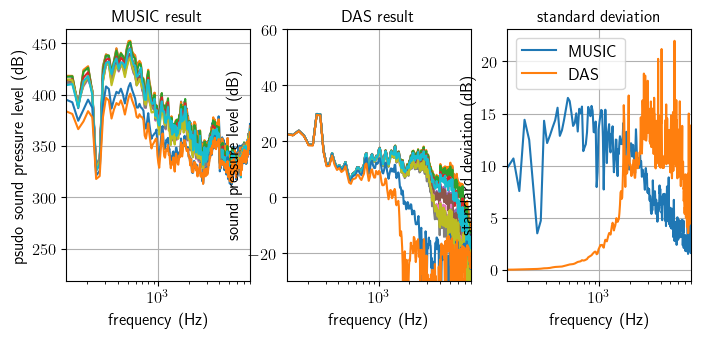

In [ ]:
import matplotlib.pyplot as plt

freq_range = [125, 8000]
plt.figure(figsize=ASPECT)
plt.subplot(1, 4, 1)
plt.title('MUSIC result')
plt.ylabel('psudo sound pressure level (dB)')
plt.xlabel('frequency (Hz)')
plt.semilogx(freq_list, result_muti_MUSIC)
plt.xlim(freq_range)
plt.grid()

plt.subplot(1, 4, 2)
plt.title('DAS result')
plt.ylabel('sound pressure level (dB)')
plt.xlabel('frequency (Hz)')
plt.semilogx(freq_list, result_muti_DAS)
plt.xlim(freq_range)
plt.ylim([-30, 60])

plt.grid()

plt.subplot(1, 4, 3)
plt.semilogx(freq_list, np.std(result_muti_MUSIC, axis=1))
plt.semilogx(freq_list, np.std(result_muti_DAS, axis=1))
plt.title('standard deviation')
plt.ylabel('standard deviation (dB)')
plt.xlabel('frequency (Hz)')
plt.legend(['MUSIC', 'DAS'])
plt.xlim(freq_range)
plt.grid()


In [ ]:
# write the modification of model to the file
o3d.io.write_point_cloud(cpcd_path, cpcd)
o3d.io.write_point_cloud(mic_path, pcd_mic)

True

In [ ]:
processor.pcd_show()

In [25]:
# align the pcd coordinates
cpcd, picked_points = processor.coordinates_align()

origin = processor.apply_rotation(pcd_mic, picked_points)
# apply translation
pcd_mic = processor.apply_translation(pcd_mic, origin)

NameError: name 'processor' is not defined

In [ ]:
o3d.visualization.draw_geometries([cpcd, processor.mesh_frame, pcd_mic])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [ ]:
processor.pcd_crop()

Task exception was never retrieved
future: <Task finished name='Task-1566' coro=<WebSocketWriter.ping() done, defined at c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py:705> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\asyncio\tasks.py", line 232, in __step
    result = coro.send(None)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 709, in ping
    await self._send_frame(message, WSMsgType.PING)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "c:\Users\ZHLI\AppData\Local\anaconda3\envs\jpylab-env\lib\site-packages\aiohttp\http_websocket.py", line 696, in _write
    raise ConnectionResetError("Cannot write to closing transport

NameError: name 'processor' is not defined

In [ ]:
plotter_add_slice.show()

A view with name (P_0x1c5a4e4a020_22) is already registered
 => returning previous one


Widget(value="<iframe src='http://localhost:53282/index.html?ui=P_0x1c5a4e4a020_22&reconnect=auto' style='widt…

TypeError: object of type 'int' has no len()

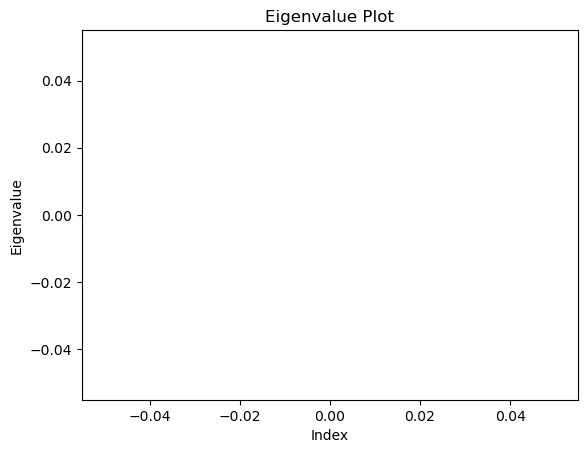

In [ ]:
import matplotlib.pyplot as plt

eigenval = BF_analysis.eigVal
plt.plot(eigenval)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Plot')
plt.xticks(range(len(eigenval)), range(len(eigenval)))
plt.show()

